In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dask import delayed

In [8]:
def simulation(N,p,gamma,steps,dt):
    J = p[:N*N].reshape((N,N))     
    np.fill_diagonal(J,0)          
    h = p[N*N:]                    
    
    S = [-np.ones(N)]
    for i in tqdm(range(1,steps)):
        s = np.copy(S[-1])
        H = h + np.dot(J,s)
        p_flip = gamma*dt*0.5*(1-s*np.tanh(H))
        p = np.random.rand(N)
        s[p<p_flip]*=-1
        S.append(s)
    S = np.array(S).T
    return S

def C_and_Cdot(S,dt):
    N = S.shape[0]
    C = np.dot(S, S.T)/S.shape[1]
    C_dot = np.dot(S[:,1:], S[:,:-1].T)/(S.shape[1]-1)
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot      

def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = (h + np.dot(J,S).T).T
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    
    #new
    np.fill_diagonal(G_0,0)
    return np.concatenate((G_0.flatten(),G_1))
    
def parralel_grad(p,S_split,C,C_dot,gamma):
    ris = []
    for S in S_split:
        ris.append(delayed(grad_L)(p,S,C,C_dot,gamma))
    grad = delayed(sum)(ris).compute()/len(S_split)
    return grad

def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

def L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #### A #####
    A = np.dot(S.T,h)
    A = np.mean(A)
    
    #### B #####
    B = J*(C_dot/gamma + C)
    B = np.sum(B)
    
    #### C #####
    C = np.tile(h,(N_t,1)).T
    C += np.dot(J,S)
    C = - logcosh(C)
    C = np.mean(np.sum(C,axis=0))
    
    L = A+B+C
    return L

def parralel_L(p,S_split,C,C_dot,gamma):
    ris = []
    for S in S_split:
        ris.append(delayed(L)(p,S,C,C_dot,gamma))
    L_ = delayed(sum)(ris).compute()/len(S_split)
    return L_

def plot_S(S): 
    plt.figure(figsize=(15,5))
    plt.imshow(S,aspect = 'auto', cmap = 'binary', interpolation = 'None')
    plt.title(S.shape)

In [9]:
!ls

59_neurons_60k_steps.npy		  parallel_inference.ipynb
DATA					  README.md
kinetic_ising_simulation_inference.ipynb  real_data_inference.ipynb


## Setup

(59, 240000)


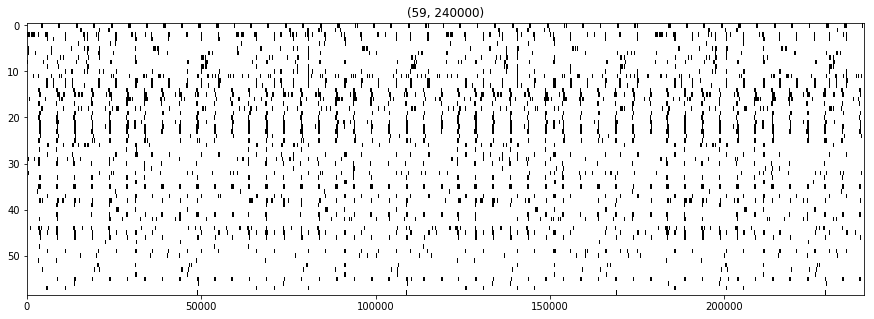

In [24]:
S = np.load('59_neurons_60k_steps.npy')
#-----------------------TRICK-------------------------------------#
S = np.concatenate((S,S,S,S),axis=1)
#-----------------------params------------------------------------#
gamma = 1
dt = 0.1
N, steps = S.shape

C,C_dot = C_and_Cdot(S,dt)
#-----------------------n cores------------------------------------#
n_cores = 10 #10 is the best

S_split = np.array_split(S,n_cores,axis = 1)
#del S
print(S.shape)
plot_S(S)

In [25]:
p = np.random.normal(0,1,N*N+N)
%time parralel_grad(p,S_split,C,C_dot,gamma)
%time grad_L(p,S,C,C_dot,gamma)

%time parralel_L(p,S_split,C,C_dot,gamma)
%time L(p,S,C,C_dot,gamma)

CPU times: user 2.6 s, sys: 5.43 s, total: 8.03 s
Wall time: 271 ms
CPU times: user 2.43 s, sys: 4.8 s, total: 7.22 s
Wall time: 866 ms
CPU times: user 1.95 s, sys: 4.93 s, total: 6.88 s
Wall time: 243 ms
CPU times: user 2.32 s, sys: 5.81 s, total: 8.13 s
Wall time: 914 ms


-327.7056550567444

### GA with momentum

100%|██████████| 400/400 [03:08<00:00,  2.12it/s]

0.28651837667305735 -9.54082147508


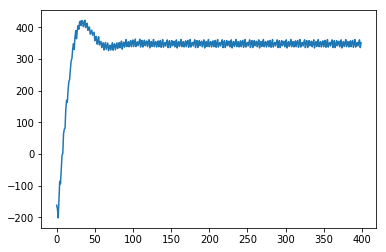

In [31]:
np.random.seed(2010)
p_mom = np.random.normal(0,1,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
Steps = 400
l_r = np.linspace(0.1,0.1,Steps)
fric = 0.9

LAMBDA = 0.1

conv_prof = []
for i in tqdm(range(Steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma) - LAMBDA*p_mom
    v = fric*v + l_r[i] * g
    p_mom += v
    conv_prof.append(parralel_L(p_mom,S_split,C,C_dot,gamma))
      
plt.plot(conv_prof)
print(np.max(p_mom),np.min(p_mom))

### RMS PROP + regularization

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

2.7792356164452694 -85.00100113645246


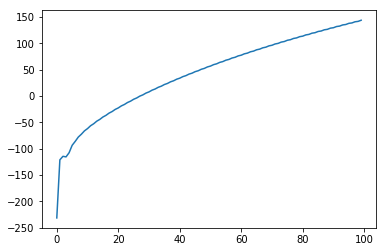

In [27]:
np.random.seed(1234)
p_rms = np.random.normal(0,1,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
Steps = 100
l_r = 0.05
beta = 0.9
eps = 10**(-8)

LAMBDA = 0.1

conv_prof = []
for i in tqdm(range(Steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma) - LAMBDA*p_rms
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    conv_prof.append(parralel_L(p_rms,S_split,C,C_dot,gamma))
    

plt.plot(conv_prof)
print(np.max(p_mom),np.min(p_mom))

## Comparison

In [29]:
np.random.seed(123)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_rand = np.concatenate((J.flatten(),h))

100%|██████████| 239999/239999 [00:03<00:00, 73332.18it/s]


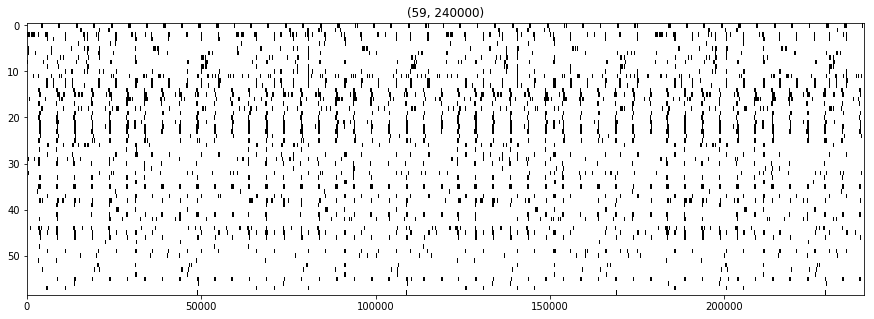

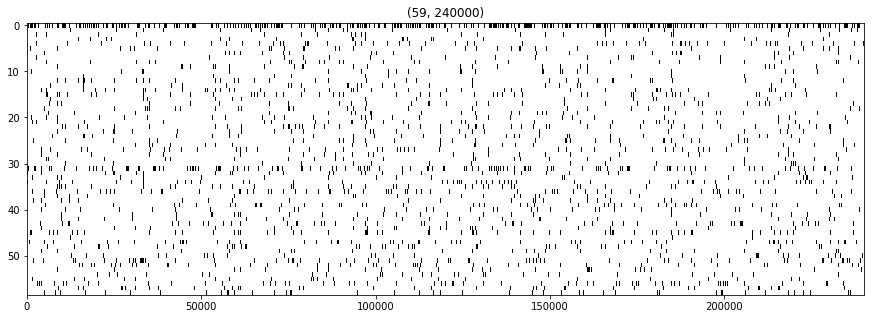

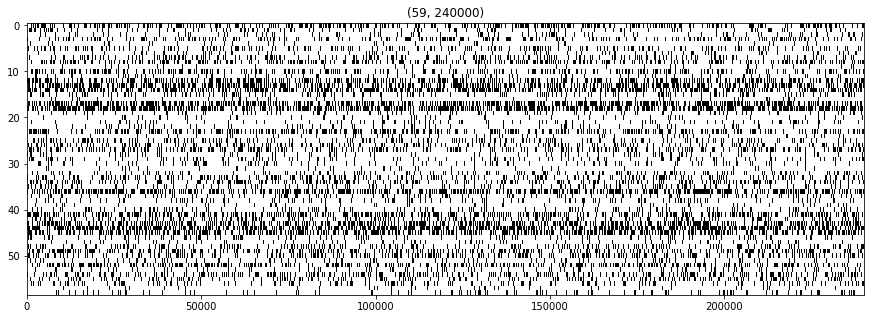

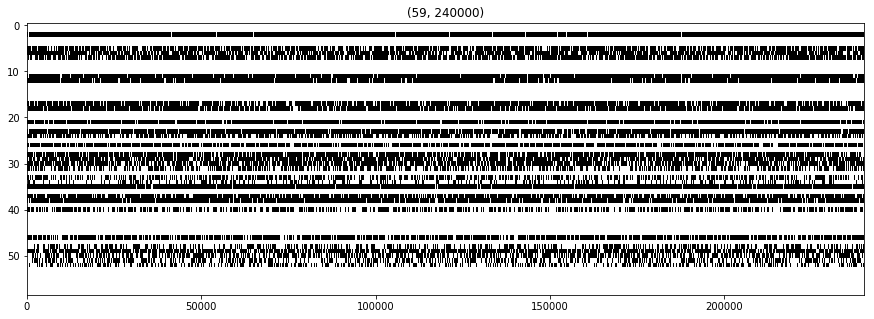

In [30]:
steps = S.shape[1]

S_rms = simulation(N,p_rms,gamma,steps,dt)
S_mom = simulation(N,p_mom,gamma,steps,dt)
S_rand = simulation(N,p_rand,gamma,steps,dt)

M = np.mean(S, axis = 1)
M_mom = np.mean(S_mom, axis = 1)
M_rms = np.mean(S_rms, axis = 1)
M_rand = np.mean(S_rand, axis = 1)

plot_S(S)
plot_S(S_mom)
plot_S(S_rms)

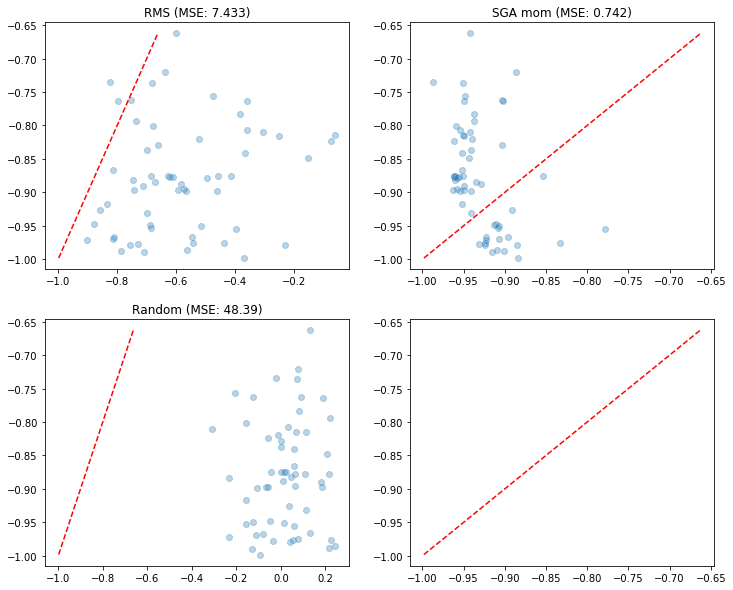

In [60]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(M_rms,M,'o',alpha = 0.3)
axs[0, 0].set_title('RMS (MSE: '+str(np.sum((M_rms-M)**2))[:5]+')')
axs[0, 1].plot(M_mom,M,'o',alpha = 0.3)
axs[0, 1].set_title('SGA mom (MSE: '+str(np.sum((M_mom-M)**2))[:5]+')')
axs[1, 0].plot(M_rand,M,'o',alpha = 0.3)
axs[1, 0].set_title('Random (MSE: '+str(np.sum((M_rand-M)**2))[:5]+')')
#axs[1, 1].plot(M_real,M,'o',alpha = 0.3)
#axs[1, 1].set_title('Real (MSE: '+str(np.sum((M_real-M)**2))[:5]+')')


for ax in axs.flat:
    ax.plot([min(M),max(M)],[min(M),max(M)],'--',color ='red')
